In [50]:
import os
import time
import pandas as pd
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from sentence_transformers import SentenceTransformer
from transformers import AutoModel, AutoTokenizer, AutoConfig

import torch.utils.data as util_data
from torch.utils.data import Dataset

In [51]:
class TextClustering(Dataset):
    def __init__(self, train_x, train_y):
        assert len(train_x) == len(train_y)
        self.train_x = train_x
        self.train_y = train_y

    def __len__(self):
        return len(self.train_x)

    def __getitem__(self, idx):
        return {'text': self.train_x[idx], 'label': self.train_y[idx]}
      

def cluster_data_loader(datapath, text, label, batch_size):
    train_data = pd.read_csv(datapath)
    train_text = train_data[text].fillna('.').values
    train_label = train_data[label].astype(int).values
    print(len(train_text), len(train_label))

    train_dataset = TextClustering(train_text, train_label)
    train_loader = util_data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # , num_workers=4)
    return train_loader

In [52]:
config = AutoConfig.from_pretrained("aws-ai/pairsupcon-bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("aws-ai/pairsupcon-bert-base-uncased")
model = AutoModel.from_pretrained("aws-ai/pairsupcon-bert-base-uncased", config=config)

Some weights of the model checkpoint at aws-ai/pairsupcon-bert-base-uncased were not used when initializing BertModel: ['contrast_head.0.weight', 'classify_head.weight', 'contrast_head.2.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [87]:
# df_data = pd.read_csv('E:\zfq\Code\Python\sccl-cpu\datasets\StackOverflow.csv')
train_loader = cluster_data_loader(
    'E:\zfq\Code\Python\sccl-cpu\datasets\AgNews.csv',
    'text',
    'label',
    8
)

8000 8000


In [88]:
for i, batch in enumerate(train_loader):
    text, label = batch['text'], batch['label']
    
    features = tokenizer.batch_encode_plus(text, max_length=200, return_tensors='pt', padding='max_length', truncation=True)
    input_ids, attention_mask = features['input_ids'].to(device), features['attention_mask'].to(device)
    bert_output = model(input_ids=input_ids, attention_mask=attention_mask)
    corpus_embeddings = torch.sum(bert_output[0]*attention_mask.unsqueeze(-1), dim=1) / torch.sum(attention_mask.unsqueeze(-1), dim=1)
    corpus_embeddings = corpus_embeddings.detach().cpu().numpy()
    break


In [89]:
features['input_ids'], tokenizer(text, max_length=200, return_tensors='pt', padding='max_length', truncation=True)

(tensor([[  101, 22245,  3021,  ...,     0,     0,     0],
         [  101,  5766, 25803,  ...,     0,     0,     0],
         [  101,  7513,  3749,  ...,     0,     0,     0],
         ...,
         [  101, 23713,  3013,  ...,     0,     0,     0],
         [  101, 26408,  3001,  ...,     0,     0,     0],
         [  101, 17714,  7065,  ...,     0,     0,     0]]),
 {'input_ids': tensor([[  101, 22245,  3021,  ...,     0,     0,     0],
         [  101,  5766, 25803,  ...,     0,     0,     0],
         [  101,  7513,  3749,  ...,     0,     0,     0],
         ...,
         [  101, 23713,  3013,  ...,     0,     0,     0],
         [  101, 26408,  3001,  ...,     0,     0,     0],
         [  101, 17714,  7065,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]), 'at

In [90]:
text, corpus_embeddings

(['bhp billiton approves chile copper project western australia iron lt gt lt gt sydney bhp billiton approved copper project northern chile costing dollars expansion iron ore operations western australia',
  'ceo pleads guilty fraud york reuters computer associates international lt href http investor reuters fullquote aspx ticker target stocks quickinfo fullquote gt lt gt chief executive sanjay kumar pleaded guilty thursday charges securities fraud obstruction justice year investigation accounting fraud company',
  'microsoft offer windows flavor retail market windows client software microsoft corp developing customized variants windows embedded operating system specific markets',
  'study amp neck stent effective surgery johnson amp johnson neck stent effective surgery clearing blocked blood vessels brain strokes death company funded study tomorrow england journal medicine',
  'china richest york expanded list names top year required personal wealth year',
  'amp cut constellation bra

In [59]:
def get_embeddings(transformer, tokenizer, train_loader, device):
    t0 = time.time()
    for i, batch in enumerate(train_loader):
        text, label = batch['text'], batch['label']
        if tokenizer is None:
            corpus_embeddings = transformer.encode(text)
        else:
            features = tokenizer.batch_encode_plus(text, max_length=200, return_tensors='pt', padding='max_length', truncation=True)
            input_ids, attention_mask = features['input_ids'].to(device), features['attention_mask'].to(device)
            bert_output = transformer.forward(input_ids=input_ids, attention_mask=attention_mask)
            corpus_embeddings = torch.sum(bert_output[0]*attention_mask.unsqueeze(-1), dim=1) / torch.sum(attention_mask.unsqueeze(-1), dim=1)
            corpus_embeddings = corpus_embeddings.detach().cpu().numpy()
            
        if i == 0:
            all_labels = label
            all_embeddings = corpus_embeddings
        else:
            all_labels = torch.cat((all_labels, label), dim=0)
            all_embeddings = np.concatenate((all_embeddings, corpus_embeddings), axis=0)
    t1 = time.time()
    print("embeddings:", all_embeddings.shape, "time consumed:",t1-t0)
    return all_labels.cpu().numpy(), all_embeddings

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
label, sentence_embeddings = get_embeddings(model, tokenizer, train_loader, device)

embeddings: (20000, 768) time consumed: 4940.935279130936


In [63]:
sentence_embeddings.shape

(20000, 768)

d:\ProgramData\Miniconda\envs\pytorch_1.8.2\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
d:\ProgramData\Miniconda\envs\pytorch_1.8.2\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
d:\ProgramData\Miniconda\envs\pytorch_1.8.2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

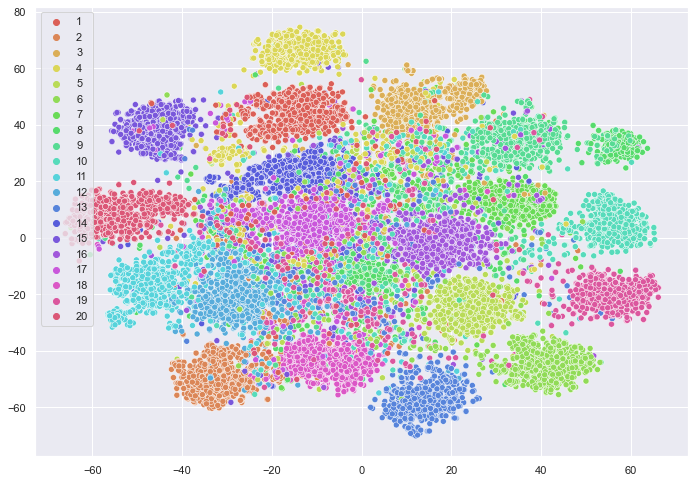

In [62]:
from sklearn.manifold import TSNE
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("hls", 20)

tsne = TSNE()
X_embedded = tsne.fit_transform(sentence_embeddings)

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=label, legend='full', palette=palette)